In [6]:
from keras_unet.utils import plot_imgs
from skimage.io import ImageCollection
from skimage.exposure import rescale_intensity
import cv2

def imread_convert(f):
  return rescale_intensity(cv2.imread(f), out_range=(0, 1))

# w folderze images_unet zmień rozszerzenia z .JPG na .jpg

def resize_image(img):
  PAD_WIDTH = [(112,), (40, ), (0, )]
  is_color = len(img.shape) > 2
  padded_img = np.pad(img, PAD_WIDTH if is_color else PAD_WIDTH[:2], 'constant')
  SCALE = 0.125 # było 0.25
  return transform.rescale(padded_img, SCALE, channel_axis=-1 if is_color else None, anti_aliasing=True)

In [7]:
import os
from imageio import imread, imsave
import numpy as np
from skimage import io
from skimage.transform import resize

import os
folders = ['images_unet', 'mask_unet', 'manual1_unet']
# folders = ['fov', 'mask']
for f in folders:
    src_dir = f"{f}"
    dest_dir = f"resized/{f}"

    # Tworzenie folderu docelowego, jeśli nie istnieje
    os.makedirs(dest_dir, exist_ok=True)

    for src_fn in os.listdir(src_dir):
        src_path = os.path.join(src_dir, src_fn)

        try:
            full_img = imread(src_path)

            # Jeśli folder to 'fov', wybierz tylko pierwszy kanał
            if f == 'fov':
                full_img = full_img[:, :, 0]

            resized_img = resize_image(full_img)

            dest_fn = os.path.splitext(src_fn)[0].replace("_mask", "") + ".png"
            dest_path = os.path.join(dest_dir, dest_fn)
            
            print(f"Saving resized image to {dest_path}, shape: {resized_img.shape}")
            
            imsave(dest_path, (resized_img * 255).astype(np.uint8))
        
        except Exception as e:
            print(f"Error processing file {src_fn}: {e}")

C:\Users\Acer\AppData\Local\Temp\ipykernel_5848\2176660493.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  full_img = imread(src_path)


Error processing file .ipynb_checkpoints: ImageIO does not generally support reading folders. Limited support may be available via specific plugins. Specify the plugin explicitly using the `plugin` kwarg, e.g. `plugin='DICOM'`
Error processing file 01_g.jpg: name 'transform' is not defined
Error processing file 01_h.jpg: name 'transform' is not defined
Error processing file 02_g.jpg: name 'transform' is not defined
Error processing file 02_h.jpg: name 'transform' is not defined
Error processing file 03_g.jpg: name 'transform' is not defined
Error processing file 03_h.jpg: name 'transform' is not defined
Error processing file 04_g.jpg: name 'transform' is not defined
Error processing file 04_h.jpg: name 'transform' is not defined
Error processing file 05_g.jpg: name 'transform' is not defined
Error processing file 05_h.jpg: name 'transform' is not defined
Error processing file 06_g.jpg: name 'transform' is not defined
Error processing file 06_h.jpg: name 'transform' is not defined
Error

In [8]:
def imread_convert(f):
  return rescale_intensity(imread(f), out_range=((0, 1)))

img_ic = ImageCollection('resized/images_unet/*.png', load_func=imread_convert)
mask_ic = ImageCollection('resized/manual1_unet/*.png', load_func=imread_convert)


In [9]:
X = img_ic.concatenate()
y = mask_ic.concatenate()
y = y.reshape(y.shape + (1,))

C:\Users\Acer\AppData\Local\Temp\ipykernel_5848\3208123049.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return rescale_intensity(imread(f), out_range=((0, 1)))


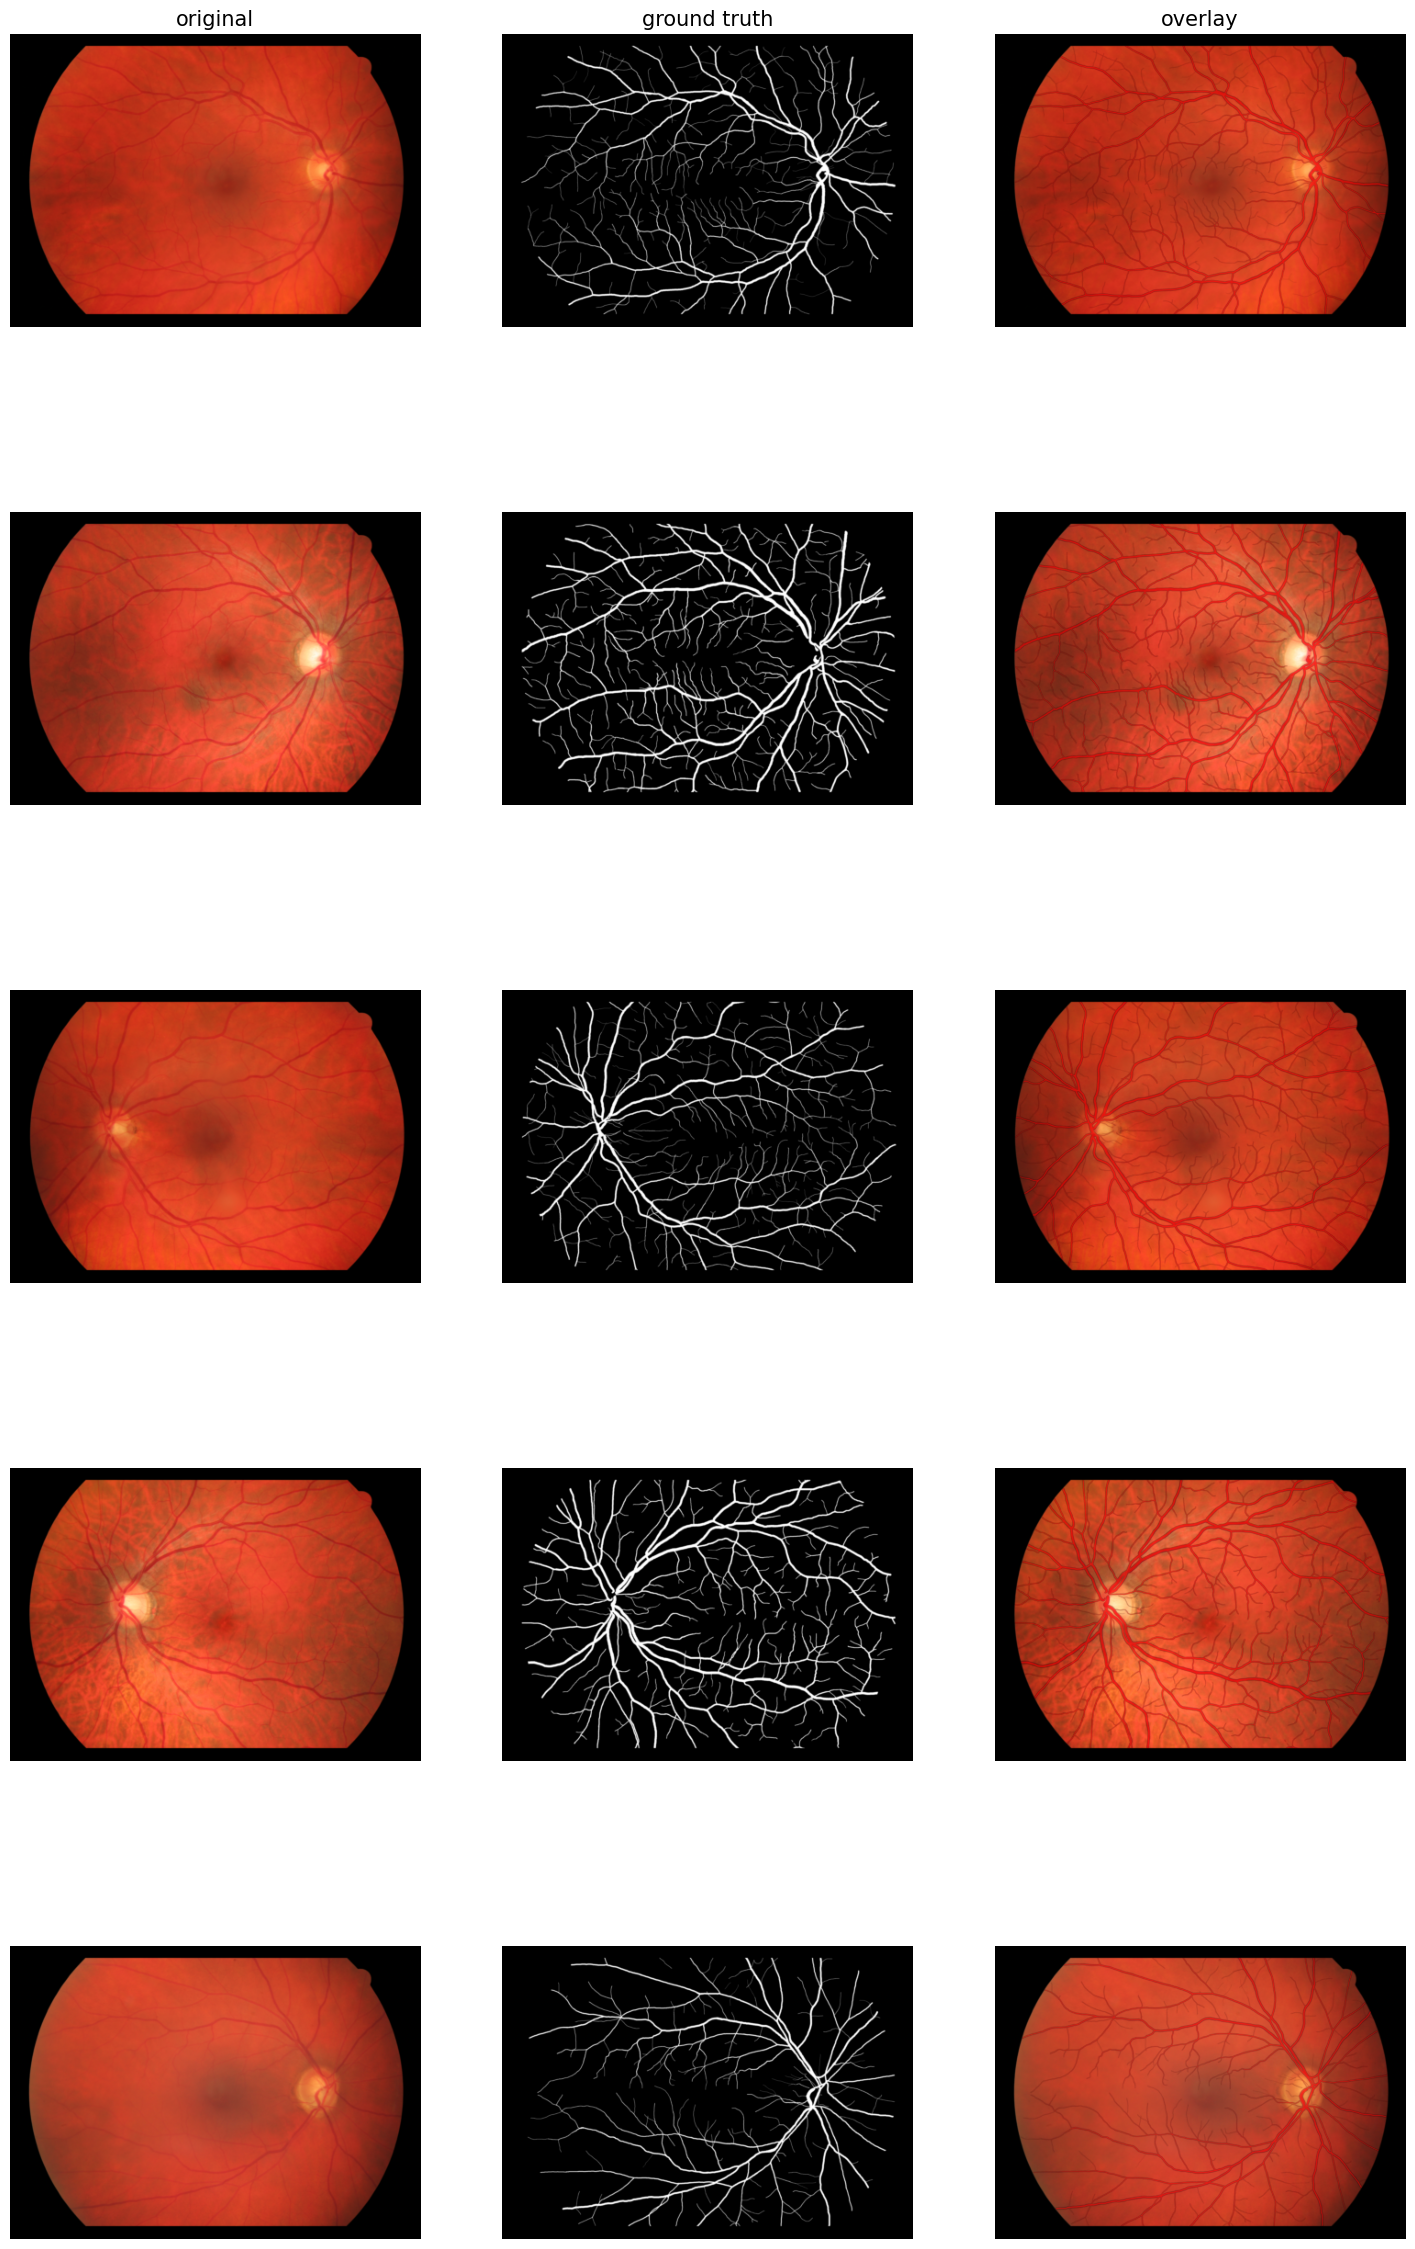

In [10]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X, mask_imgs=y, nm_img_to_plot=5, figsize=6) 

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=10, random_state=42)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)

X_train:  (20, 320, 448, 3)
y_train:  (20, 320, 448, 1)
X_val:  (10, 320, 448, 3)
y_val:  (10, 320, 448, 1)


In [18]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

(2, 320, 448, 3) (2, 320, 448, 1)


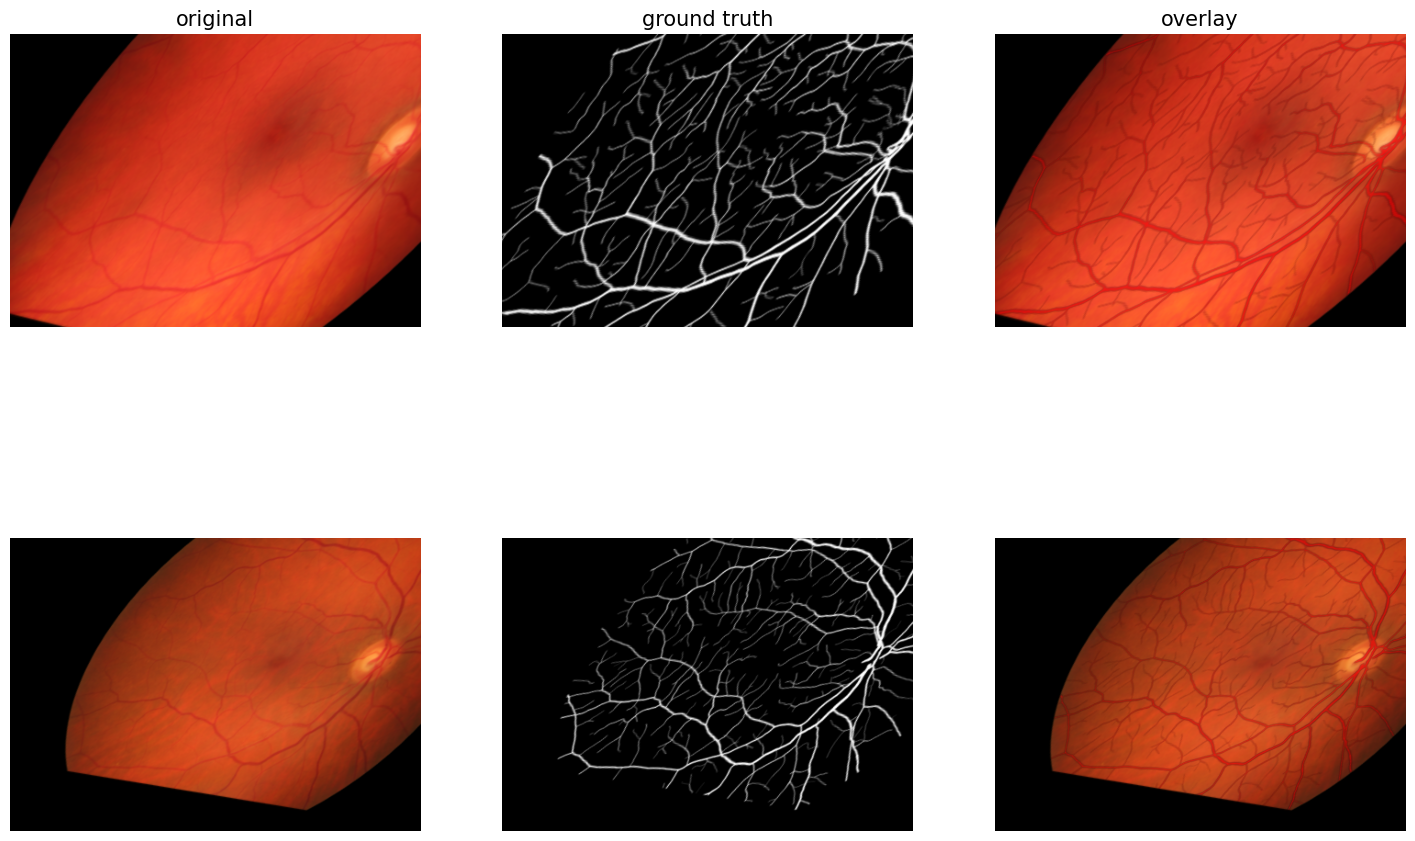

In [19]:
sample_batch = next(train_gen)
X_aug, y_aug = sample_batch
print(X_aug.shape, y_aug.shape)

from keras_unet.utils import plot_imgs
plot_imgs(org_imgs=X_aug, mask_imgs=y_aug, nm_img_to_plot=2, figsize=6)

In [20]:
input_shape = (None, None, 3)

In [21]:
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 64)       1792      ['input_1[0][0]']             
                                                                                                  
 spatial_dropout2d (Spatial  (None, None, None, 64)       0         ['conv2d[0][0]']              
 Dropout2D)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 64)       36928     ['spatial_dropout2d[0][0]'

In [31]:
from keras.callbacks import ModelCheckpoint


model_fn = 'model/fundus.h5'
callback_checkpoint = ModelCheckpoint(
    model_fn,
    verbose=1,
    monitor='val_loss',
    save_best_only=True,
)

In [32]:
from tensorflow.keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.99),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [25]:
history = model.fit(
    train_gen,
    steps_per_epoch=100,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[callback_checkpoint]
)

Epoch 1/20


  6/100 [>.............................] - ETA: 12:09 - loss: 0.5920 - iou: 0.0556 - iou_thresholded: 0.0253

KeyboardInterrupt: 

In [ ]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [35]:
model_fn = model.load_weights("model/fundus.h5")

In [36]:
y_pred = model.predict(X_val)

1/1 [==============================] - 7s 7s/step


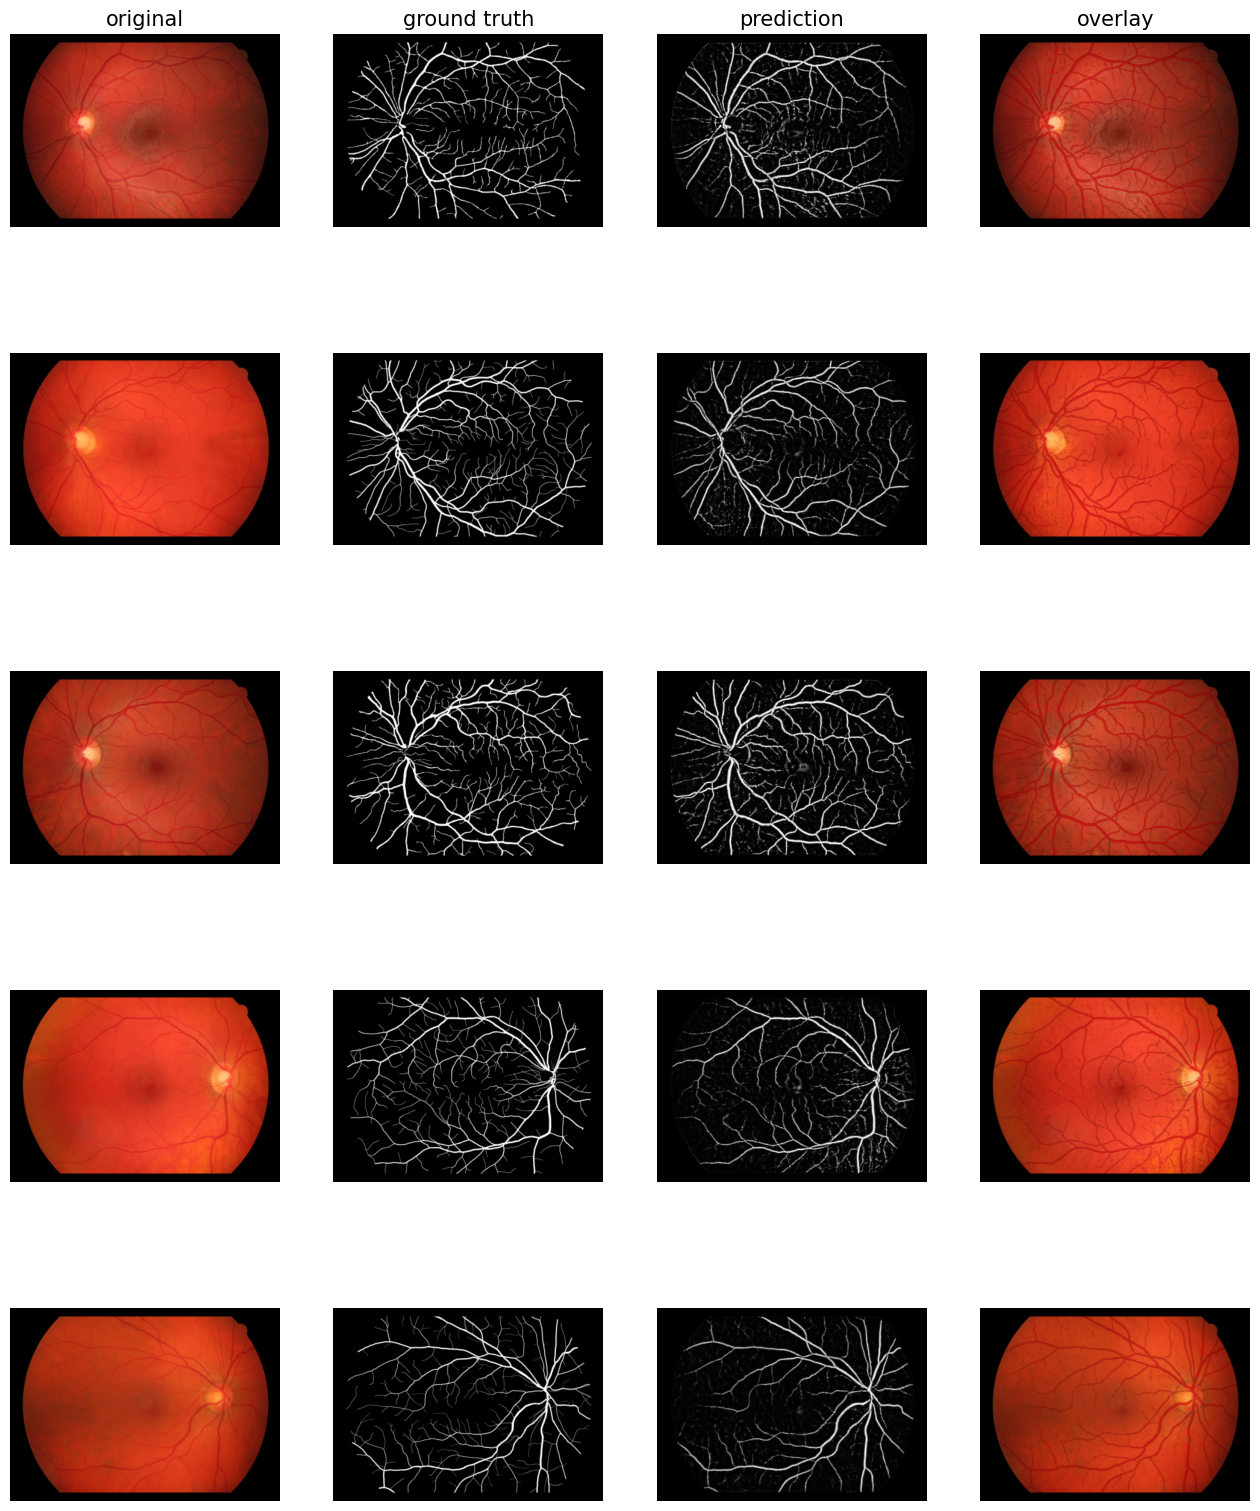

In [37]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=5)

In [41]:
import numpy as np
from skimage import io
from skimage.exposure import rescale_intensity
from skimage.util import img_as_ubyte

def convert_imsave(file_name, img):
    # Check if the image is grayscale and convert accordingly
    if len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1):
        # If the image is single-channel, we need to handle it properly
        if len(img.shape) == 3:
            img = img[:, :, 0]  # Drop the single channel dimension
        img = rescale_intensity(img, out_range=(0, 255))
        img = img_as_ubyte(img)
        io.imsave(file_name, img, check_contrast=False)
    elif len(img.shape) == 3 and img.shape[2] == 3:
        # If the image is already in 3-channel RGB format
        img = rescale_intensity(img, out_range=(0, 255))
        img = img_as_ubyte(img)
        io.imsave(file_name, img, check_contrast=False)
    else:
        raise ValueError("Unsupported image shape: {}".format(img.shape))

# Assuming y_val, y_pred, and X_val are your datasets
for i in range(y_pred.shape[0]):
    convert_imsave(f"{i + 1}-y-true.png", y_val[i])
    convert_imsave(f"{i + 1}-y-pred-{i + 1}.png", y_pred[i])
    convert_imsave(f"{i + 1}-X.png", X_val[i])


ValueError: Images of type float must be between -1 and 1.